# How does cinema view the world?

This project will explore how cities and countries are depicted in cinema.

We will explore this topic from multiple aspects.

Contents:

0. [Data preprocessing](#data-preprocessing)
1. [Large Scale Analysis](#large-scale-analysis)
2. [Cityscapes](#cityscapes)
3. [Characters](#characters)
4. [Going back in time](#going-back-in-time)

## Data preprocessing

### Imports

Here we import the required libraries and helper functions we will need for the analysis.

In [8]:
import os

import pandas as pd
import numpy as np

# We use google maps to get the coordinates of the cities/countries.
import googlemaps
import cartopy.crs as ccrs

# We import all our helper functions from the helpers.py file.
from helpers import *

# To track progress we use the tqdm package.
import tqdm

# To load our generated movie analysis we will use the json package.
import json

# T-SNE for dimensionality reduction
from sklearn.manifold import TSNE

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator

# To parse genres from dataframe
import ast

# For mapping genres to colors
import hashlib

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For caching
import functools

# Statistical tests and distributions
import scipy.stats as stats
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import gaussian_kde, norm

# We hide warnings to make the notebook a bit cleaner.
import warnings
warnings.filterwarnings("ignore")

### Data loading

For the project we are using the [CMU Movie Summary Corpus](https://www.cs.cmu.edu/~ark/personas/) which contains plot summaries of 42,306 movies. The dataset also contains a number of metadata information about the movie and the actors.

We will use the following files from the dataset:
- `plot_summaries.txt` - which contains the plot summaries.
- `character.metadata.tsv` - which contains information about the characters and actors that play in a movie.
- `movie.metadata.tsv` - which contains information about movies.


As our project explores how *cinema views the world* as our main tool we have decided to analyze how the location of a movie affects the story, characters and what bias can be found.

#### Location information
The dataset does not provide the plot location to us and as such we have extracted location information using the newly released [JSON ChatGPT API](https://platform.openai.com/docs/guides/text-generation/json-mode).

With the use of the OpenAI API we have extracted the following information for each movie summary:

Example output of the movie ***Pest from the West***
```json
{
   "cities": [
      "Mexico City"
   ],
   "countries": [
      "Mexico"
   ],
   "characters": {
      "Keaton": {
         "nationality": "USA",
         "alignment": "good"
      }
   }
}
```

This data resides in the `movie_analysis.json` file. The code that helped us generate these results resides in `calculate-locations.ipynb`.

#### Embeddings
We have also computed semantic embeddings of all summaries in order to be able to get similarity metrics between movies or from a term to a movie. To calculate these embeddings we have used the [OpenAI Embeddings API](https://platform.openai.com/docs/guides/embeddings). Each embedding vector is `1536` dimensional.

The embeddings are stored in the `embeddings.npy` file. The code that helped us generate these results resides in `calculate-embeddings.ipynb`.

We will now load our preprocessed data.

In [9]:
DATA_PATH = 'data/'

# We load the data using our helper function.
loaded_data = load_data(DATA_PATH)

# We initialize the google maps client using our API key.
gmaps = googlemaps.Client(key=os.environ['GOOGLE_MAPS_API_KEY'])

# We extract the variables from the loaded data.
character_metadata = loaded_data['character_metadata'] # The metadata of the characters.
movie_metadata = loaded_data['movie_metadata'] # The metadata of the movies.
plot_summaries = loaded_data['plot_summaries'] # The plot summaries of the movies.
embeddings = loaded_data['embeddings'] # The embeddings of the movies as a numpy array.
combined_plot_summaries = loaded_data['combined_plot_summaries'] # The movie summaries combined with their embeddings.
cities_in_country = loaded_data['cities_in_country'] # city list per country
city_country_analysis = loaded_data['city_country_analysis'] # The analysis of the cities and countries.
cities = city_country_analysis['cities'] # A list of all the cities.
countries = city_country_analysis['countries'] # A list of all the countries.
cities_movies = city_country_analysis['cities_movies'] # A dictionary mapping cities to movies.
countries_movies = city_country_analysis['countries_movies'] # A dictionary mapping countries to movies.
embeddings_of_movies_in_cities = city_country_analysis['embeddings_of_movies_in_cities'] # A dictionary mapping cities to embeddings of movies.
embeddings_of_movies_in_countries = city_country_analysis['embeddings_of_movies_in_countries'] # A dictionary mapping countries to embeddings of movies.
continent_mapping = json.load(open(DATA_PATH + 'continent_mapping.json'))

# We create the plot directory if it does not exist yet.
if not os.path.exists('web/plots'):
    os.makedirs('web/plots')

## Large Scale Analysis

### Magnitude

Before we start the analysis we should first see how many movies we have that actually contain location information. As the action for a movie can be left unspecified or the location can be fictitious.

In [10]:
# We get the number of movies in each category.
initial_number_of_movies = len(movie_metadata)
initial_number_of_movies_in_plot_summaries = len(plot_summaries)
initial_number_of_movies_in_cities = len(set([movie for city in cities_movies for movie in cities_movies[city]]))
initial_number_of_movies_in_countries = len(set([movie for country in countries_movies for movie in countries_movies[country]]))

categories = ['Number of movies with metadata information', 
              'Movies with plot summaries', 
              'Movies with city present', 
              'Movies with country present']
values = [initial_number_of_movies, 
          initial_number_of_movies_in_plot_summaries, 
          initial_number_of_movies_in_cities, 
          initial_number_of_movies_in_countries]

# Sorting data
sorted_categories, sorted_values = zip(*sorted(zip(categories, values), key=lambda x: x[1], reverse=True))

# Creating the bar chart
fig = go.Figure(data=[
    go.Bar(
        x=sorted_values,
        y=sorted_categories,
        orientation='h',
        text=[f'{value:,}' for value in sorted_values],
        textposition='auto',
        marker_color=px.colors.qualitative.Set2,
        hoverinfo='none'
    )
])

# Updating layout
fig.update_layout(
    title='Number of Movies in Each Category',
    xaxis_title='Number of Movies',
    yaxis_title='Category',
    yaxis=dict(autorange="reversed"),
    template="plotly_white"
)

# Saving the figure as an HTML file
fig.write_html('web/plots/number_of_movies.html')
fig.show()

### Distribution

Here we have a look at how the data we have acquired is distributed over the countries.

In [4]:
# Initialize lists to store latitudes, longitudes, and sizes
lats, lngs, sizes, found_countries = [], [], [], []

# Loop over the countries and geocode them
for country, movies in countries_movies.items():
    geocode_result = gmaps.geocode(country)
    if geocode_result:
        lat = geocode_result[0]["geometry"]["location"]["lat"]
        lng = geocode_result[0]["geometry"]["location"]["lng"]
        lats.append(lat)
        lngs.append(lng)
        sizes.append(len(movies))
        found_countries.append(country)

We will now plot this data into a two sided plot showing a map but also a bar chart.

In [ ]:
# Number of countries to show in the bar chart
top_n = 10

# We sort the countries by the number of movies.
sorted_data = sorted(zip(found_countries, sizes), key=lambda x: x[1], reverse=True)[:top_n]
sorted_countries, sorted_sizes = zip(*sorted_data)

# The hover text for the map
map_hover_text = [f'{country}: {size} movies' for country, size in zip(found_countries, sizes)]

# Creating the figure
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.7, 0.3],  
    specs=[[{'type': 'scattergeo'}, {'type': 'bar'}]]
)

# Adding the map
fig.add_trace(
    go.Scattergeo(
        lon=lngs,
        lat=lats,
        text=map_hover_text,
        mode='markers',
        marker=dict(
            size=[size / 10 for size in sizes],  
            opacity=0.8,
            color='red',
            line=dict(width=0),
            sizemode='area'
        ),
        hoverinfo='text'
    ),
    row=1, col=1
)

# Adding the bar chart
fig.add_trace(
    go.Bar(
        x=list(reversed(sorted_sizes)),
        y=list(reversed(sorted_countries)),
        orientation='h',
        text=list(reversed(sorted_sizes)),
        textposition='auto',
        marker_color=px.colors.qualitative.Plotly,
        hoverinfo='none',
    ),
    row=1, col=2
)


fig.update_geos(
    projection_type="natural earth",
    showcountries=True,
    showland=True,
    landcolor='lightgrey',
    showocean=True,
    oceancolor='lightblue',
    row=1, col=1,
)


fig.update_layout(
    barmode='group',
    bargap=0.15,  
    title_text="World Map with Movie Locations and Top Countries",
    showlegend=False
)


# Saving the figure as an HTML file
fig.write_html('web/plots/interactive_movie_locations.html')
fig.show()

### Genre analysis

In [ ]:
locations_to_remove = ["Brooklyn", "Hollywood", "Manhattan", "California"]

for location in locations_to_remove:
    cities_movies.pop(location, None)

In [ ]:
def get_genres_by_location(locations_movies, movie_metadata):
    location_genre_count = {}

    for location, movie_ids in locations_movies.items():
        genre_count = {}

        for movie_id in movie_ids:
            genres_series = movie_metadata.loc[movie_metadata["Wikipedia movie ID"] == int(movie_id), "Movie genres (Freebase ID:name tuples)"]
            if not genres_series.empty:
                genres_str = genres_series.values[0]
                genres = list(ast.literal_eval(genres_str).values())

                for genre_name in genres:
                    genre_count[genre_name] = genre_count.get(genre_name, 0) + 1

        location_genre_count[location] = genre_count

    return location_genre_count


In [ ]:
city_genre = get_genres_by_location(cities_movies, movie_metadata)
country_genre = get_genres_by_location(countries_movies, movie_metadata)

In [ ]:
GENRE_SIGNIFICANCE_THRESHOLD = 0.03  # Threshold for genre representation

def hash_color(genre, s=0.5):
    hash = hashlib.md5(genre.encode()).hexdigest()
    r, g, b = int(hash[0:2], 16), int(hash[2:4], 16), int(hash[4:6], 16)
    r, g, b = [int(s * val + (1 - s) * 255) for val in (r, g, b)]
    return f'#{r:02x}{g:02x}{b:02x}'


In [ ]:
def visualize_genres(location, genres, set_visible=False):
    total_count = sum(genres.values())
    filtered_genres_counts = {
        genre: (count / total_count) * 100
        for genre, count in genres.items()
        if (count / total_count) >= GENRE_SIGNIFICANCE_THRESHOLD
    }
    sorted_genres_counts = dict(sorted(filtered_genres_counts.items(), key=lambda item: item[1], reverse=True))

    bar_colors = [hash_color(genre) for genre in sorted_genres_counts.keys()]

    genre_counts = [genres[genre] for genre in sorted_genres_counts.keys()]

    trace = go.Bar(
        x=list(sorted_genres_counts.keys()),
        y=list(sorted_genres_counts.values()),
        marker=dict(color=bar_colors),
        visible=set_visible,
        width=0.3, 
        text=[f'{value:.2f}%' for value in sorted_genres_counts.values()],
        textposition='outside',
        customdata=genre_counts,
        name=location,
        hovertemplate='%{x}<br>%{y:.2f}%<br>Movies: %{customdata}<extra></extra>'
    )

    return trace

In [ ]:
china_trace = visualize_genres('China', country_genre['China'], set_visible=True)
japan_trace = visualize_genres('Japan', country_genre['Japan'])
india_trace = visualize_genres('India', country_genre['India'])
germany_trace = visualize_genres('Germany', country_genre['Germany'])
north_korea_trace = visualize_genres('North Korea', country_genre['North Korea'])
france_trace = visualize_genres('France', country_genre['France'])
ussr_trace = visualize_genres('Soviet Union', country_genre['USSR'])
romania_trace = visualize_genres('Romania', country_genre['Romania'])
vietnam_trace = visualize_genres('Vietnam', country_genre['Vietnam'])
afghanistan_trace = visualize_genres('Afghanistan', country_genre['Afghanistan'])

fig = go.Figure()
fig.add_traces([china_trace, japan_trace, india_trace, germany_trace, north_korea_trace, france_trace, ussr_trace, romania_trace, vietnam_trace, afghanistan_trace])

fig.update_layout(
    xaxis=dict(
        tickangle=45 
    )
)

num_traces = len(fig.data)
visibility_states = [[False] * num_traces for _ in range(num_traces)]

for i in range(num_traces):
    visibility_states[i][i] = True

buttons = [
    dict(method='update',
         label=fig.data[i].name, 
         args=[{'visible': visibility_states[i]},
               {'title': f'Genre Distribution for {fig.data[i].name}'}])
    for i in range(num_traces)
]

fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
    }]
)

fig.show()


We will now verify that the genre differences are meaningful!

In [ ]:
# We calculate the percentage of movies in each genre for each country.
percentages_by_country = {
    country: {
        genre: (count / sum(genre_counts.values()))
        for genre, count in genre_counts.items()
    }
    for country, genre_counts in country_genre.items()
}

# We use a hypothetical total of 1000 movies to calculate the expected counts.
hypothetical_total = 1000
country_genre_counts = {country: {genre: pct * hypothetical_total for genre, pct in genres.items()}
                        for country, genres in percentages_by_country.items()}


df_country_genre_counts = pd.DataFrame(country_genre_counts).fillna(0)

# Calculate the Chi-Square Test of Independence
chi2, p, dof, expected = chi2_contingency(df_country_genre_counts)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")

if p < 0.05:
    print("Reject null hypothesis")

### Embeddings

Embeddings are highly dimensional vectors that represent meaning of a piece of text.
We have utilised embeddings in our project in order to observe small fluctuations in movie preferences of countries over time but also for cluster analysis and comparison of different countries.

In [ ]:
# We show the embedding of a random movie
random_movie = np.random.choice(len(embeddings))
embedding_to_visualize = embeddings[random_movie]
embedding_to_visualize = np.array([round(value, 3) for value in embedding_to_visualize])

fig, ax = plt.subplots(figsize=(10, 1))
ax.text(0.5, 0.5, str(embedding_to_visualize), fontsize=16, va='center', ha='center')
# Title should be down a bit
ax.set_title(f'Embedding Vector (1536 Dimensions)', fontsize=16)
ax.axis('off')
plt.savefig('web/plots/embedding.png', bbox_inches='tight')
plt.show()

In order to visualize embeddings which are usually 1536 dimensional we will need to bring them down to 2 dimensions. We will do this by using the TSNE algorithm.

In [11]:
# We calculate the T-SNE embedding of all movies
tsne = TSNE(n_components=2, random_state=0)
tsne_obj = tsne.fit_transform(embeddings) if not os.path.exists('data/tsne.npy') else np.load('data/tsne.npy')

# We save the T-SNE embedding
np.save('data/tsne.npy', tsne_obj)

We will now look at search terms in our embedding space!

In [ ]:
# List of search terms to consider
search_terms = ["War", "Love", "Bollywood", "Horror"]

# We get the embeddings for each search term
search_terms_embeddings = [get_embedding(term) for term in search_terms]

# Calculate cosine similarities for each search term
cosine_similarities_dict = {}
for term, search_embedding in zip(search_terms, search_terms_embeddings):
    cosine_similarities_dict[term] = np.dot(embeddings, search_embedding)

# We get all movie names for each movie that has an embedding
movie_names = get_movie_names_from_ids(combined_plot_summaries['Wikipedia movie ID'].values, movie_metadata)

# Initial plot with the first search term
initial_term = search_terms[0]
tsne_df = pd.DataFrame({'X': tsne_obj[:, 0], 'Y': tsne_obj[:, 1], 'Movie': movie_names, 'Color': cosine_similarities_dict[initial_term]})

We will now plot the embeddings and their similarities to the search terms

In [ ]:
# We now plot the T-SNE embedding
fig = go.Figure(data=go.Scattergl(
    x=tsne_df['X'], 
    y=tsne_df['Y'],
    mode='markers',
    marker=dict(
        color=tsne_df['Color'],
        colorscale='RdBu',
        colorbar=dict(title='Cosine Similarity')
    ),
    text=tsne_df['Movie'],
    hoverinfo='text'
))

# Dropdown menu for switching between terms
fig.update_layout(
    title=f'T-SNE plot of movie embeddings for search of {initial_term}',
    xaxis_title='T-SNE Dimension 1',
    yaxis_title='T-SNE Dimension 2',
    updatemenus=[
        dict(
            active=0,
            buttons=list(
                [
                    dict(
                        label=term,
                        method="update",
                        args=[{"marker.color": [cosine_similarities_dict[term]]},
                              {"title": f'T-SNE plot of movie embeddings for search of {term}'}]
                    ) for term in search_terms
                ]
            )
        )
    ]
)

# We save the figure as an HTML file
fig.show()
fig.write_html("web/plots/tsne.html", include_plotlyjs="cdn")

Lets observe a number of countries and examine how their clusters look like

In [ ]:
# We hardcode some countries to check.
countries_to_check = [
    'France',
    'Germany',
    'Italy',
    'Spain',
    'China',
    'Vietnam',
    'Japan',
    'India',
    'South Korea',
    'United States',
    'United Kingdom',
    'Russia',
]

# We get all movies in these countries.
movies_in_countries_to_check = [countries_movies[country] for country in countries_to_check]

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']*100
# We get the embeddings of these movies from T-SNE by using the indices in combined_plot_summaries.
tsne_movies_in_countries_to_check = [tsne_obj[combined_plot_summaries[combined_plot_summaries['Wikipedia movie ID'].isin(movies)].index] for movies in movies_in_countries_to_check]
data = {}
for i, country in enumerate(countries_to_check):
    country_movies = tsne_movies_in_countries_to_check[i]
    movie_names = get_movie_names_from_ids(movies_in_countries_to_check[i], movie_metadata)
    
    x_country, y_country = [movie[0] for movie in country_movies], [movie[1] for movie in country_movies]
    data[country] = {'x': x_country, 'y': y_country, 'color': colors[i], 'names': movie_names}

In [ ]:
# Create the main figure
fig = go.Figure()

# Function that computes the KDE for a set of points
def compute_kde(x, y):
    kde = gaussian_kde(np.vstack([x, y]))
    x_grid, y_grid = np.mgrid[min(x)-20:max(x) + 20 :100j, min(y)-20:max(y) + 20:100j]
    z = kde(np.vstack([x_grid.ravel(), y_grid.ravel()]))
    x_grid = x_grid.ravel()
    y_grid = y_grid.ravel()
    return x_grid, y_grid, z.reshape(x_grid.shape)

# We add our initial trace with all movies
fig.add_trace(go.Scattergl(x=tsne_obj[:, 0], y=tsne_obj[:, 1], mode='markers', 
                           marker=dict(color='gray', opacity=0.1), 
                           name='All Movies', 
                           hoverinfo='skip'))

# Add traces for each country
for i, (country, values) in enumerate(data.items()):
    # Compute KDE for the country
    x_grid, y_grid, z = compute_kde(values['x'], values['y'])

    # We add both a point trace and a contour trace for each country
    fig.add_trace(go.Scattergl(x=values['x'], y=values['y'], mode='markers', 
                               marker=dict(color='blue'), 
                               visible=(i == 0), 
                               opacity=0.4,
                               name=f'Movies in {country}',
                               text=values['names'],
                               hoverinfo='text'))
    
    fig.add_trace(go.Contour(x=x_grid, y=y_grid, z=z, 
                             showscale=False, visible=(i == 0), 
                             colorscale='Blues', 
                             opacity=1, 
                             ncontours=10,
                             hoverinfo='skip',
                             contours=dict(coloring='fill', showlines=True),
                             name=f'{country} Density'))

# We add a dropdown menu to switch between countries
dropdown_buttons = [
    dict(method='update',
         label=country,
         args=[{'visible': [True] + [j == i*2 or j == i*2 + 1 for j in range(2 * len(countries_to_check))]},
               {'title': f'T-SNE of Movies - Highlighting {country}'}])
    for i, country in enumerate(countries_to_check)
]

fig.update_layout(
    updatemenus=[
        dict(
            buttons=dropdown_buttons,
            direction='down',
            showactive=True,
            xanchor='right',
            yanchor='top',
            bgcolor='white',
            bordercolor='black',
            font=dict(size=12, color='black')
        ),
    ],
    title='Interactive T-SNE of Movies - Highlighting {}'.format(countries_to_check[0]),
    xaxis_title='t-SNE Axis 1',
    yaxis_title='t-SNE Axis 2',
)

# Save as html file
fig.write_html("web/plots/tsne_countries.html", include_plotlyjs="cdn")

# Show the figure
fig.show()

### IMDB Ratings

Here we will explore how imdb ratings are influenced by the location, looking at countries and continents.

Here we setup the data for the imdb ratings and create the required dataframes

In [ ]:
movie_ratings = pd.read_csv(DATA_PATH + "title.ratings.tsv", sep="\t")

movie_ratings["tconst"] = movie_ratings["tconst"].apply(lambda ttconst: ttconst[2:])
movie_ratings.rename(columns={"tconst": "imdb_id"}, inplace=True)

imdb_data = pd.read_csv(DATA_PATH + "movie_imdb.csv")
imdb_data_rating = imdb_data.dropna(subset=["imdb_rating"])
imdb_data_rating.drop(columns=["filming_locations", "imdb_rating"], inplace=True)
imdb_data_rating = imdb_data_rating.merge(movie_ratings, on="imdb_id")

movie_to_cities = {"Wikipedia movie ID": [], "City": []}
movie_to_cities_dict = {}

for city in cities_movies:
    for movie_id in cities_movies[city]:
        if movie_id not in movie_to_cities_dict:
            movie_to_cities_dict[movie_id] = {"cities": None}
        if movie_to_cities_dict[movie_id]["cities"] is None:
            movie_to_cities_dict[movie_id]["cities"] = city
        else:
            movie_to_cities_dict[movie_id]["cities"] = movie_to_cities_dict[movie_id]["cities"] + "|" + city

            
for key in movie_to_cities_dict:
    for city in movie_to_cities_dict[key]["cities"].split("|"):
        movie_to_cities["Wikipedia movie ID"].append(key)
        movie_to_cities["City"].append(city)
        
movies_to_countries = {"Wikipedia movie ID": [], "Country": []}
movies_to_countries_dict = {}

for country in countries_movies:
    for movie_id in countries_movies[country]:
        if movie_id not in movies_to_countries_dict:
            movies_to_countries_dict[movie_id] = {"countries": None}
        if movies_to_countries_dict[movie_id]["countries"] is None:
            movies_to_countries_dict[movie_id]["countries"] = country
        else:
            movies_to_countries_dict[movie_id]["countries"] = movies_to_countries_dict[movie_id]["countries"] + "|" + country
            
for key in movies_to_countries_dict:
    for country in movies_to_countries_dict[key]["countries"].split("|"):
        movies_to_countries["Wikipedia movie ID"].append(key)
        movies_to_countries["Country"].append(country)

city_imdb = imdb_data_rating.merge(pd.DataFrame.from_dict(movie_to_cities), on="Wikipedia movie ID")
country_imdb = imdb_data_rating.merge(pd.DataFrame.from_dict(movies_to_countries), on="Wikipedia movie ID")

city_imdb_with_genres = city_imdb.merge(movie_metadata, on="Wikipedia movie ID")
city_imdb_with_genres["Movie genres (Freebase ID:name tuples)"] = city_imdb_with_genres["Movie genres (Freebase ID:name tuples)"].apply(lambda genres: ast.literal_eval(genres).values())
city_imdb_with_genres.drop(columns=["Freebase movie ID", "Movie name", "Movie release date", "Movie runtime", "Movie languages (Freebase ID:name tuples)", "Movie countries (Freebase ID:name tuples)", "Movie box office revenue"], inplace=True)
city_imdb_with_genres.rename(columns={"Movie genres (Freebase ID:name tuples)": "genres"}, inplace=True)

country_imdb_with_genres = country_imdb.merge(movie_metadata, on="Wikipedia movie ID")
country_imdb_with_genres["Movie genres (Freebase ID:name tuples)"] = country_imdb_with_genres["Movie genres (Freebase ID:name tuples)"].apply(lambda genres: ast.literal_eval(genres).values())
country_imdb_with_genres.drop(columns=["Freebase movie ID", "Movie name", "Movie release date", "Movie runtime", "Movie languages (Freebase ID:name tuples)", "Movie countries (Freebase ID:name tuples)", "Movie box office revenue"], inplace=True)
country_imdb_with_genres.rename(columns={"Movie genres (Freebase ID:name tuples)": "genres"}, inplace=True)

def filter_genres_by_list(genres, genres_list):
    return any(genre in genres for genre in genres_list)

def imdb_rating_scaled_and_votes(group):
    votes = group['numVotes']
    ratings = group['averageRating']
    max_votes = votes.max()
    normalized_votes = votes / max_votes if max_votes else 0
    #weighted_average = np.sum(ratings * normalized_votes) / np.sum(normalized_votes) if max_votes else 0
    weighted_average = np.mean(ratings) # just take the mean as of now
    total_votes = np.sum(votes)
    num_movies = len(ratings)
    return pd.Series({'imdb_rating': weighted_average, 'number_of_votes': total_votes, 'number_of_movies': num_movies})

def get_city_imdb_ratings(city_imdb, genres=None):
    if genres is None:
        return city_imdb.groupby('City').apply(imdb_rating_scaled_and_votes).reset_index()
    else:
        filtered = city_imdb[city_imdb['genres'].apply(lambda x: filter_genres_by_list(x, genres))]
        return filtered.groupby('City').apply(imdb_rating_scaled_and_votes).reset_index()
    
    
def get_list_of_movies_in_cities_by_genres(city_imdb, genres=None):
    grouped_stuff = []
    if genres is None:
        grouped_stuff =  city_imdb.groupby('City')
    else:
        grouped_stuff = city_imdb[city_imdb['genres'].apply(lambda x: filter_genres_by_list(x, genres))].groupby('City')
    
    # We return a dictionary mapping cities to a list of movies.
    return {city: list(group['averageRating']) for city, group in grouped_stuff}

def get_list_of_movies_in_countries_by_genres(country_imdb, genres=None):
    grouped_stuff = []
    if genres is None:
        grouped_stuff =  country_imdb.groupby('Country')
    else:
        grouped_stuff = country_imdb[country_imdb['genres'].apply(lambda x: filter_genres_by_list(x, genres))].groupby('Country')
    
    # We return a dictionary mapping cities to a list of movies.
    return {city: list(group['averageRating']) for city, group in grouped_stuff}



@functools.lru_cache(maxsize=512)
def get_continent(city_name):
    geocode_result = gmaps.geocode(city_name)
    
    if len(geocode_result) == 0:
        return None
    for address_component in geocode_result[0]['address_components']:
        if 'country' in address_component['types']:
            country_name = address_component['short_name']
            return continent_mapping[country_name]

We will first take a look at continents taking into account genres and show if the results are significant.

In [ ]:
# The genres we want to check. None represents all genres.
genres_to_check = [
    None,
    'Drama',
    'War film',
    'Martial Arts Film',
    'Romantic drama',
    'Comedy',
    'Horror',
]

results_to_show, significance_results_pairs = [], []

# For each genre we will compute the results to show but also an ANOVA test and a Tukey HSD test.
for genre in genres_to_check:
    # We get the movies from this genre in each country
    movies_in_countries = get_list_of_movies_in_countries_by_genres(country_imdb_with_genres, [genre] if genre is not None else None)
    # We get their continents.
    continents = [get_continent(country) for country in movies_in_countries]
    
    # We remove Antarctica.
    if 'Antarctica' in continents:
        continents.remove('Antarctica')
        
    # We merge the movies in each continent.
    movies_in_continents = {continent: [] for continent in set(continents)}

    for i, continent in enumerate(continents):
        movies_in_continents[continent] += movies_in_countries[list(movies_in_countries.keys())[i]]
    
    movies_in_continents.pop(None, None)
    
    # We perform the ANOVA test.
    values_to_test = [movies_in_continents[continent] for continent in movies_in_continents]
    f_value, p_value = stats.f_oneway(*values_to_test)

    # We calculate the average rating per continent.
    averaged_movies_in_continents = {continent: np.mean(movies_in_continents[continent]) for continent in movies_in_continents}
    
    # We also will like to show the number of movies per continent.
    num_movies_in_continents = {continent: len(movies_in_continents[continent]) for continent in movies_in_continents}
    
    # We show the average rating per continent.
    if genre is None:
        genre = 'All Genres'
    
    # We append the results to show.
    results_to_show.append((genre, averaged_movies_in_continents, p_value, num_movies_in_continents))
    
    # We now perform the Tukey HSD test.
    
    # We flatten the list of movies.
    flattened_movies = [movie for movies in values_to_test for movie in movies]
    
    # We create a list of continents for each movie.
    continents_for_movies = []
    for continent, movies in movies_in_continents.items():
        continents_for_movies += [continent] * len(movies)
        
    # We perform the Tukey HSD test.
    tukey_results = pairwise_tukeyhsd(flattened_movies, continents_for_movies, alpha=0.05)
    
    # We get the results in a dataframe.
    tukey_results_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
    
    # We get the pairs of continents that are significantly different.
    significant_pairs = tukey_results_df[tukey_results_df['reject'] == True][['group1', 'group2']].values
    
    # Order in a > b
    significant_pairs = [(pair[0], pair[1]) if averaged_movies_in_continents[pair[0]] > averaged_movies_in_continents[pair[1]] else (pair[1], pair[0]) for pair in significant_pairs]

    # We add the pairs to the list.
    significance_results_pairs.append((genre, significant_pairs))


# We create the figure.
fig = go.Figure()

# We add the traces for each genre.
for genre, averaged_movies_in_continents, p_value, number_of_movies_per_continent in results_to_show:
    fig.add_trace(go.Bar(
        visible=True,
        x=list(averaged_movies_in_continents.keys()),
        y=list(averaged_movies_in_continents.values()),
        customdata=list(zip(number_of_movies_per_continent.values(), [genre] * len(number_of_movies_per_continent))),
        text=[f'{value:.2f}' for value in averaged_movies_in_continents.values()],
        hovertemplate='Continent: %{x}<br>Average IMDB Rating: %{y:.2f}/10<br>Number of Movies: %{customdata[0]}<br>Genre: %{customdata[1]}<extra></extra>',
        name=f'{genre} (p-value: {p_value:.2f})'
    ))
    
# We update the layout.
fig.update_layout(
    title='Average IMDB Rating per Continent for All Genres',
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(
                    label=genre,
                    method="update",
                    args=[{"visible": [genre == result[0] for result in results_to_show] if genre != 'All Genres' else [True] * len(results_to_show)},
                          {"title": f"Average IMDB Rating per Continent for {genre}"}]
                ) for genre, _, _, _ in results_to_show
        
            ]),
        )
    ])

# Save as html file
fig.show()
fig.write_html("web/plots/average_imdb_rating_per_continent.html", include_plotlyjs="cdn")

We will now create a table plot to see where the tukey test has identified significant problems

In [ ]:
# Create a Plotly figure
fig = go.Figure()

# For each genre we add a table with the significant pairs
for genre, significant_pairs in significance_results_pairs:
    df = pd.DataFrame(significant_pairs, columns=['Higher Average (Continent A)', 'Lower Average (Continent B)'])
    fig.add_trace(go.Table(
        header=dict(values=df.columns, fill_color='paleturquoise', align='left'),
        cells=dict(values=[df[col] for col in df.columns], fill_color='lavender', align='left'),
        visible=False if genre != significance_results_pairs[0][0] else True,
        name=genre
    ))

# Dropdown menu for switching between genres
buttons = []
for i, (genre, _) in enumerate(significance_results_pairs):
    buttons.append(
        dict(
            label=genre,
            method="update",
            args=[{"visible": [j == i for j in range(len(significance_results_pairs))]},
                  {"title": f"Significant Differences (p < 0.05) in Average IMDB Rating per Continent for {genre}"}]
        )
    )

fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons)],
    title="Significant Differences (p < 0.05) in Average IMDB Rating per Continent for All Genres",
    margin=dict(t=100, b=100)
)

# Save as html file
fig.write_html("web/plots/significant_differences_per_continent.html", include_plotlyjs="cdn")
fig.show()

## Cityscapes

### Most Popular city in movies per country of production

In [ ]:
top10_countries = ['Mexico', 'Italy', 'Australia', 'Germany', 'China', 'Japan', 'India', 'France', 'United Kingdom', 'United States']

filtered_cities_movies = {city: cities_movies[city] for country in top10_countries 
                          for city in cities_in_country[country] 
                          if city in cities_movies}

city_movie_counts = {city: len(movies) for city, movies in filtered_cities_movies.items()}

popular_city_per_country = {}
for country in top10_countries:
    cities = cities_in_country[country]
    city_counts = {city: city_movie_counts.get(city, 0) for city in cities}
    most_popular_city = max(city_counts, key=city_counts.get)
    popular_city_per_country[country] = (most_popular_city, city_counts[most_popular_city])

local_foreign_movie_counts = {}
for country, (city, count) in popular_city_per_country.items():
    local_count = len([movie for movie in filtered_cities_movies[city] if movie in countries_movies[country]])
    foreign_count = count - local_count
    local_foreign_movie_counts[country] = (local_count, foreign_count)


local_foreign_movie_percentages = {}
for country, (local_count, foreign_count) in local_foreign_movie_counts.items():
    total_count = local_count + foreign_count
    if total_count > 0:
        local_percentage = (local_count / total_count) * 100
        foreign_percentage = (foreign_count / total_count) * 100
        local_foreign_movie_percentages[country] = (local_percentage, foreign_percentage)


In [ ]:
movie_counts = [popular_city_per_country[country][1] for country in top10_countries]
local_percentages = [local_foreign_movie_percentages[country][0] for country in top10_countries]
foreign_percentages = [local_foreign_movie_percentages[country][1] for country in top10_countries]


# Generate two palettes with 10 distinct colors each
palette = sns.color_palette('pastel', n_colors=10)

hex_colors = palette.as_hex()

fig = go.Figure()
annotations = []
for idx, country in enumerate(top10_countries):
    # Calculate the total number of movies for the stacked bar
    total_movies = movie_counts[idx]
    local_movies = round(total_movies * (local_percentages[idx] / 100))
    foreign_movies = total_movies - local_movies
    
    fig.add_trace(go.Bar(
        x=[local_movies, foreign_movies],
        y=[country, country],
        orientation='h',
        name=f'{popular_city_per_country[country][0]} - Local: {local_percentages[idx]:.2f}%, Foreign: {foreign_percentages[idx]:.2f}%',
        marker=dict(color=[hex_colors[idx], hex_colors[idx]], pattern_shape = ["", "\\"]),  # Apply color to each segment
        hoverinfo='none'
    ))



 # Prepare the annotation text for this bar
    annotations.append(dict(
        x=total_movies,  # Position the annotation in the middle of the bar
        y=country,
        text=f'{popular_city_per_country[country][0]} - {total_movies} movies',
        font=dict(size=10),  # Adjust the font size as needed
        showarrow=False,
        xanchor='left'  # Ensure the annotation is centered on the specified x position
    ))



fig.update_layout(
    title='Most Popular City per Country in Movies (with Local and Foreign Production Percentages)',
    xaxis_title='Number of Movies',
    yaxis_title='Country',
    yaxis=dict(autorange=True,categoryorder='total ascending'),
    template="plotly_white",
    barmode = 'stack',
    annotations=annotations  # Add the annotations to the layout
)
fig.show()

fig.write_html("web/plots/most_popular_cities.html", include_plotlyjs="cdn")

### Genre analysis

In [ ]:
paris_trace = visualize_genres('Paris', city_genre['Paris'], set_visible=True)
tokyo_trace = visualize_genres('Tokyo', city_genre['Tokyo'])
new_york_trace = visualize_genres('New York', city_genre['New York'])
las_vegas_trace = visualize_genres('Las Vegas', city_genre['Las Vegas'])
berlin_trace = visualize_genres('Berlin', city_genre['Berlin'])
mumbai_trace = visualize_genres('Mumbai', city_genre['Mumbai'])
venice_trace = visualize_genres('Venice', city_genre['Venice'])
hong_kong_trace = visualize_genres('Hong Kong', city_genre['Hong Kong'])
london_trace = visualize_genres('London', city_genre['London'])
beijing_trace = visualize_genres('Beijing', city_genre['Beijing'])
beverly_hills_trace = visualize_genres('Beverly Hills', city_genre['Beverly Hills'])

fig = go.Figure()
fig.add_traces([paris_trace, tokyo_trace, mumbai_trace, hong_kong_trace, venice_trace, las_vegas_trace, new_york_trace, berlin_trace, london_trace, beijing_trace, beverly_hills_trace])

fig.update_layout(
    xaxis=dict(
        tickangle=45 
    )
)

num_traces = len(fig.data)
visibility_states = [[False] * num_traces for _ in range(num_traces)]

for i in range(num_traces):
    visibility_states[i][i] = True

buttons = [
    dict(method='update',
         label=fig.data[i].name, 
         args=[{'visible': visibility_states[i]},
               {'title': f'Genre Distribution for {fig.data[i].name}'}])
    for i in range(num_traces)
]

fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
    }]
)

fig.show()


### IMDb ratings

In [ ]:
city_ratings = get_city_imdb_ratings(city_imdb)

In [ ]:
mu, std = norm.fit(city_ratings['imdb_rating'])

xmin, xmax = city_ratings['imdb_rating'].min(), city_ratings['imdb_rating'].max()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.hist(city_ratings['imdb_rating'], bins=30, alpha=0.5, density=True)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f, std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('IMDb Rating')
plt.ylabel('Density')
plt.show()

In [ ]:
def create_scatter_trace(city_ratings, set_visible=False):
    return go.Scatter(
        x=city_ratings['imdb_rating'],
        y=city_ratings['number_of_movies'],
        mode='markers+text',
        marker=dict(
            size=city_ratings['number_of_votes'],
            sizemode='area',
            sizeref=2.*max(city_ratings['number_of_votes'])/(70.**2)
        ),
        text=city_ratings['City'],
        hoverinfo='text',
        name="",
        textposition="middle center",
        hovertemplate='<b>%{text}</b><br>' +
                      'IMDb Rating: %{x}<br>' +
                      'Number of Movies: %{y}<br>' +
                      'Number of Votes: %{marker.size:,}',
        visible=set_visible,
    )

In [ ]:
fig = go.Figure()

city_ratings_romance = get_city_imdb_ratings(city_imdb_with_genres, genres=["Romance Film", "Romantic Drama"])
city_ratings_romance = city_ratings_romance[city_ratings_romance["number_of_movies"] > 40]
fig.add_trace(create_scatter_trace(city_ratings_romance, set_visible=True))

city_ratings_horror = get_city_imdb_ratings(city_imdb_with_genres, genres=["Horror"])
city_ratings_horror = city_ratings_horror[city_ratings_horror["number_of_movies"] > 10]
fig.add_trace(create_scatter_trace(city_ratings_horror))

city_ratings_martial_arts = get_city_imdb_ratings(city_imdb_with_genres, genres=["Martial Arts Film"])
city_ratings_martial_arts = city_ratings_martial_arts[city_ratings_martial_arts["number_of_movies"] > 5]
fig.add_trace(create_scatter_trace(city_ratings_martial_arts))

city_ratings_bollywood = get_city_imdb_ratings(city_imdb_with_genres, genres=["Bollywood"])
city_ratings_bollywood = city_ratings_bollywood[city_ratings_bollywood["number_of_movies"] > 10]
fig.add_trace(create_scatter_trace(city_ratings_bollywood))


buttons = [
    dict(method='update',
         label='Romance Movies',
         args=[{'visible': [True, False, False, False]},
               {'title': 'IMDb ratings for Romance Movies'}]),
    dict(method='update',
         label='Horror Movies',
         args=[{'visible': [False, True, False, False]},
               {'title': 'IMDb ratings for Horror Movies'}]),
    dict(method='update',
         label='Martial Arts Movies',
         args=[{'visible': [False, False, True, False]},
               {'title': 'IMDb ratings for Martial Arts Movies'}]),
    dict(method='update',
         label='Bollywood Movies',
         args=[{'visible': [False, False, False, True]},
               {'title': 'IMDb ratings for Bollywood Movies'}])
]

fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
    }],
    title='Average IMDb Rating per City',
    xaxis=dict(title='Average IMDb Rating'),
    yaxis=dict(title='Number of Movies'),
)

# Show the plot
fig.show()

We will now check our results for significance using ANOVA and 

In [ ]:
# Genres we will check. None represents all genres.
genres_to_check = [
    None,
    'Martial Arts Film',
    'Romance Film',
    'Horror',
    'Bollywood'
]

significance_results_pairs = []

# For each genre we will compute the results to show but also a Tukey HSD test.
for genre in genres_to_check:
    # We get the movies from this genre in each city
    movies_in_cities = get_list_of_movies_in_cities_by_genres(city_imdb_with_genres, [genre] if genre is not None else None)
    
    # We filter out cities with less than 5 movies.
    movies_in_cities = {city: movies for city, movies in movies_in_cities.items() if len(movies) >= 5}
    
    # We get the values to test.
    values_to_test = [movies_in_cities[city] for city in movies_in_cities]
    
    # We calculate the average rating per city.
    averaged_movies_in_cities = {city: np.mean(movies_in_cities[city]) for city in movies_in_cities}
    
    # Also add number of movies per city
    num_movies_in_cities = {city: len(movies_in_cities[city]) for city in movies_in_cities}
    
    # We now perform the Tukey HSD test.

    # We flatten the list of movies.
    flattened_movies = [movie for movies in values_to_test for movie in movies]
    
    # We create a list of cities for each movie.
    cities_for_movies = []
    for city, movies in movies_in_cities.items():
        cities_for_movies += [city] * len(movies)
        
    # We perform the Tukey HSD test.
    tukey_results = pairwise_tukeyhsd(flattened_movies, cities_for_movies, alpha=0.05)
    
    # We get the results in a dataframe.
    tukey_results_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
    
    # We get the pairs of cities that are significantly different.
    significant_pairs = tukey_results_df[tukey_results_df['reject'] == True][['group1', 'group2']].values
    
    # Order in a > b
    significant_pairs = [(pair[0], pair[1]) if averaged_movies_in_cities[pair[0]] > averaged_movies_in_cities[pair[1]] else (pair[1], pair[0]) for pair in significant_pairs]

    # We add the pairs to the list.
    if genre is None:
        genre = 'All Genres'
    significance_results_pairs.append((genre, significant_pairs))

We plot a similar plot that we did for continents but for cities now

In [ ]:
fig = go.Figure()

# For each genre we add a table with the significant pairs
for genre, significant_pairs in significance_results_pairs:
    df = pd.DataFrame(significant_pairs, columns=['Higher Average (City A)', 'Lower Average (City B)'])
    fig.add_trace(go.Table(
        header=dict(values=df.columns, fill_color='paleturquoise', align='left'),
        cells=dict(values=[df[col] for col in df.columns], fill_color='lavender', align='left'),
        visible=False if genre != significance_results_pairs[0][0] else True,
        name=genre
    ))

# Create a dropdown menu for selecting a genre
buttons = []
for i, (genre, _) in enumerate(significance_results_pairs):
    buttons.append(
        dict(
            label=genre,
            method="update",
            args=[{"visible": [j == i for j in range(len(significance_results_pairs))]},
                  {"title": f"Significant Differences (p < 0.05) in Average IMDB Rating per City for {genre}"}]
        )
    )

fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons)],
    title="Significant Differences (p < 0.05) in Average IMDB Rating per City for All Genres",
    margin=dict(t=100, b=100)
)

# Save as html file
fig.show()
fig.write_html("web/plots/significant_differences_per_city.html", include_plotlyjs="cdn")

## Characters

## Going back in time

118


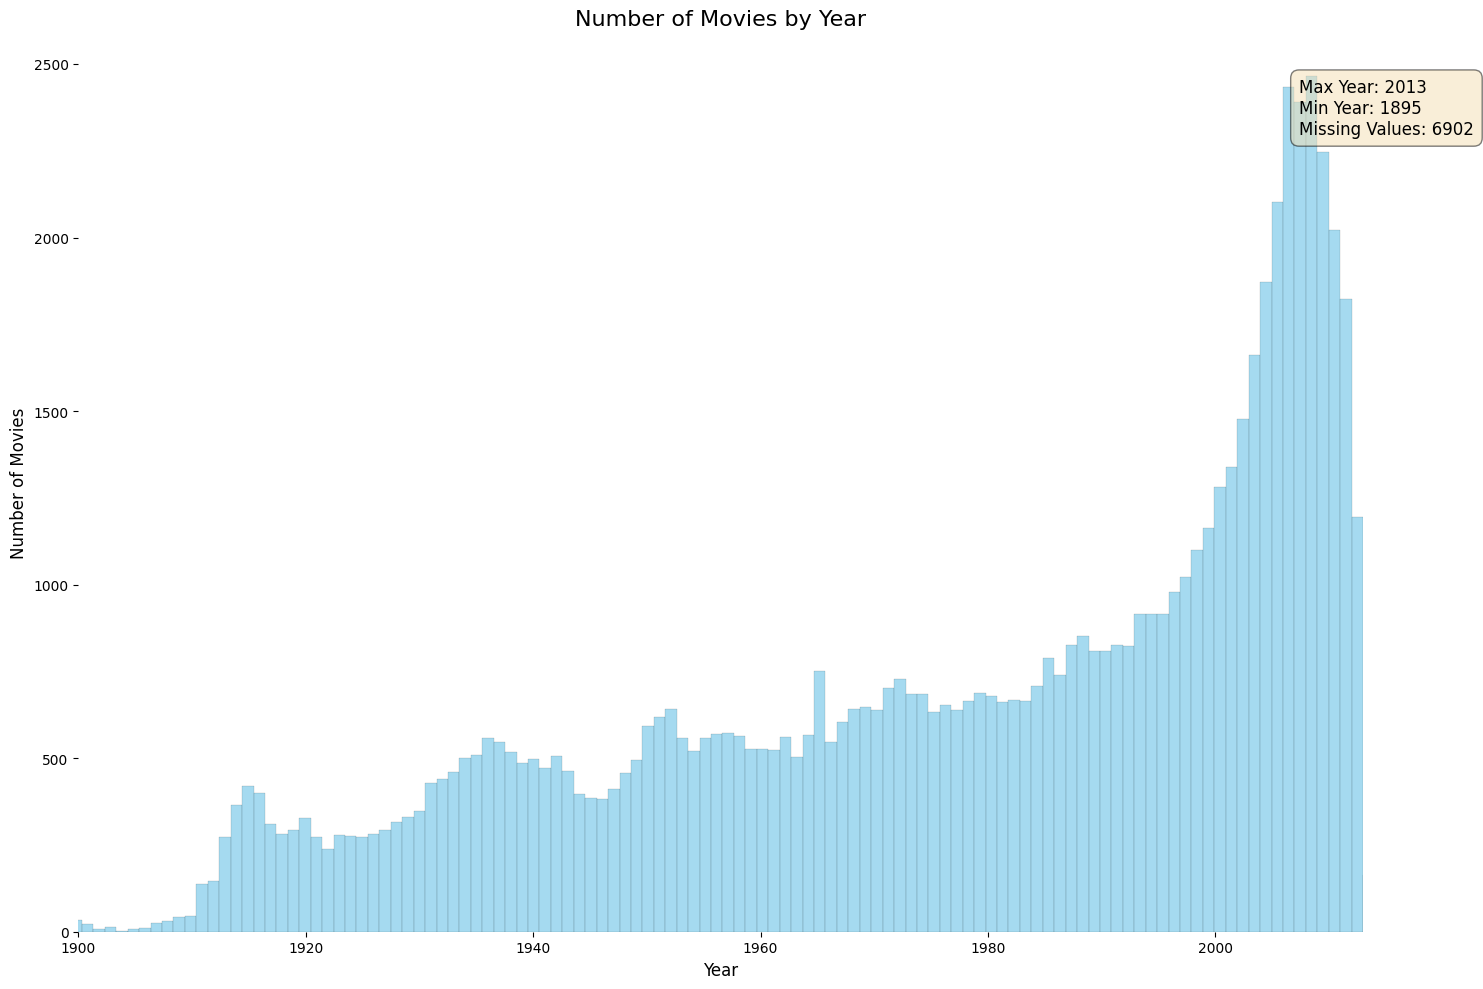

In [15]:
movie_years = movie_metadata['Movie release date'].str.extract(r'(\d{4})', expand=False)

# Calculate min, max, and missing values
min_year = 1895
max_year = 2013
missing_values = movie_years.isnull().sum()

# Drop NA values and convert to int
movie_years = movie_years.dropna().astype(int)

# Histogram of movie years
fig, ax = plt.subplots(figsize=(15, 10))
print(max_year - min_year)
sns.histplot(movie_years, bins=(1000), color='skyblue', ax=ax, kde=False)

# Set labels and title
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Movies', fontsize=12)
ax.set_title('Number of Movies by Year', fontsize=16)

ax.set_xlim([1900, max_year])

# Adding text about min, max, and missing values
textstr = f'Max Year: {max_year}\nMin Year: {min_year}\nMissing Values: {missing_values}'
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.5))

plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.savefig('web/plots/number_of_movies_by_year.png')

plt.show()


### Genre Evolution

In [ ]:
def get_genres_by_location_and_year(locations_movies, movie_metadata):
    year_location_genre_count = {}

    for location, movie_ids in locations_movies.items():
        for movie_id in movie_ids:
            movie_row = movie_metadata[movie_metadata["Wikipedia movie ID"] == int(movie_id)]

            if not movie_row.empty:
                movie_release_date = movie_row["Movie release date"].values[0]
                year = movie_release_date[:4] if pd.notna(movie_release_date) else 'Unknown'

                genres_str = movie_row["Movie genres (Freebase ID:name tuples)"].values[0]
                genres = list(ast.literal_eval(genres_str).values())

                if year not in year_location_genre_count:
                    year_location_genre_count[year] = {}
                if location not in year_location_genre_count[year]:
                    year_location_genre_count[year][location] = {}

                for genre_name in genres:
                    genre_count = year_location_genre_count[year][location]
                    genre_count[genre_name] = genre_count.get(genre_name, 0) + 1

    return year_location_genre_count

In [ ]:
year_city_genre = get_genres_by_location_and_year(cities_movies, movie_metadata)
year_country_genre = get_genres_by_location_and_year(countries_movies, movie_metadata)

In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def genre_trend_visualization(location, genres, location_year_genre_data, years_range, percentage=True, window=5, mark_years=[], mark_years_labels=[]):
    plt.figure(figsize=(10, 6))

    start_year = years_range[0]
    end_year = years_range[-1]
    all_years = list(range(start_year, end_year + 1))
    
    max_genre_value = 0

    # Calculate the counts or percentages for each year
    for genre in genres:
        annual_data = []
        for year in all_years:
            year_str = str(year)
            total_movies = sum(location_year_genre_data.get(year_str, {}).get(location, {}).values())
            genre_count = location_year_genre_data.get(year_str, {}).get(location, {}).get(genre, 0)
            if percentage and total_movies > 0:
                genre_value = (genre_count / total_movies) * 100
            else:
                genre_value = genre_count
            annual_data.append(genre_value)

        # Apply smoothing
        if len(annual_data) >= window:
            smoothed_data = moving_average(annual_data, window)
            max_genre_value = max(max_genre_value, max(smoothed_data))
            # Plot the data
            plt.plot(all_years[window-1:], smoothed_data, label=genre, linewidth=2)

    
    for i, year in enumerate(mark_years):
        plt.axvline(x=year, color='gray', linestyle='--')
        plt.text(year, max_genre_value, mark_years_labels[i], ha='center', va='bottom')

    
    ylabel = 'Percentage of Movies' if percentage else 'Number of Movies'
    plt.title(f'Genre evolution in {location}')
    plt.xlabel('Year')
    plt.ylabel(ylabel)

    # Set x-axis ticks to only show every fifth year
    plt.xticks(range(start_year, end_year + 1, window))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.legend()
    plt.grid(True)
    
    plt.show()


In [ ]:
genre_trend_visualization(
    "France",
    ["War film", "Romance Film", "Black-and-white"],
    year_country_genre,
    range(1920, 2010), 
    percentage=True,
    window=5,
    mark_years=[1939, 1945],
    mark_years_labels=['WW2', 'WW2']
)

In [ ]:
genre_trend_visualization(
    "Germany",
    ["War film"],
    year_country_genre,
    range(1920, 2010),
    percentage=True,
    window=5,
    mark_years=[1939, 1945],
    mark_years_labels=['WW2', 'WW2']
)

In [ ]:
genre_trend_visualization(
    "United Kingdom",
    ["War film"],
    year_country_genre,
    range(1920, 2010),
    percentage=True,
    window=5,
    mark_years=[1939, 1945],
    mark_years_labels=['WW2', 'WW2']
)

In [ ]:
genre_trend_visualization(
    "Hong Kong",
    ["Action", "Martial Arts Film", "Action/Adventure"],
    year_city_genre,
    range(1920, 2010),
    percentage=True,
    window=5,
    mark_years=[1970],
    mark_years_labels=['Action Movies Boom']
)

In [ ]:
genre_trend_visualization(
    "India",
    ["Musical", "Bollywood", "British Empire Film"],
    year_country_genre,
    range(1920, 2010),
    percentage=True,
    window=10,
    mark_years=[1947],
    mark_years_labels=['India Independence']
)

In [ ]:

def movies_per_time(movies_in_country_to_check, world, path_name, country_to_check):
    movie_years = movie_metadata['Movie release date'].str.extract(r'(\d{4})', expand=False)
    movie_metadata['year'] = movie_years
    movie_metadata['year'] = movie_metadata['year'].fillna(-1).astype(int)

    # Define the time periods
    time_periods = range(1900, 2017, 20)

    n_ranges = len(time_periods)
    n_cols = 3
    n_rows = (n_ranges + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 10 * n_rows))

    axes = axes.flatten()

    for i, start_year in enumerate(time_periods):
        end_year = start_year + 20
    
        # Filter movies released in the current time period
        period_movies = movie_metadata[(movie_metadata['year'] < end_year) & (movie_metadata['year'] >= start_year)]
    
        ax = axes[i]

        if world == True:
            movies_in_country_to_check_in_time_period = period_movies['Wikipedia movie ID']
        else:
            movies_in_country_to_check_in_time_period = period_movies[period_movies['Wikipedia movie ID'].isin(movies_in_country_to_check)]['Wikipedia movie ID']
        tsne_movies_in_country_to_check = tsne_obj[combined_plot_summaries['Wikipedia movie ID'].isin(movies_in_country_to_check_in_time_period)]

        country_movies = tsne_movies_in_country_to_check
        x_country, y_country = [movie[0] for movie in country_movies], [movie[1] for movie in country_movies]

        # Scatter plot for all movies
        ax.scatter(tsne_obj[:, 0], tsne_obj[:, 1], color='gray', alpha=0.2)

        # Scatter plot for the highlighted movies
        ax.scatter(x_country, y_country, alpha=0.5, color='red')

        # KDE plot for the highlighted movies
        sns.kdeplot(x=x_country, y=y_country, ax=ax, cmap='Reds', shade=True,  alpha=0.7)
    
        # Set titles and labels
        if world == True:
            ax.set_title(f'{len(movies_in_country_to_check_in_time_period)} movies between {start_year} - {end_year}', pad=20, fontsize=20)
        else:
            ax.set_title(f'{country_to_check} with {len(movies_in_country_to_check_in_time_period)} movies between {start_year} - {end_year}', pad=20, fontsize=20)
        ax.set_xlabel('t-SNE Axis 1', fontsize=15)
        ax.set_ylabel('t-SNE Axis 2', fontsize=15)
    
        # Set x adn y limits
        ax.set_xlim([-90, 90])
        ax.set_ylim([-90, 90])
    

    # Adjust layout
    plt.tight_layout()
    sns.despine(left=True, bottom=True)
    plt.savefig(path_name)

    plt.close()

In [ ]:
movies_per_time(list(countries_movies.values()), True, 'web/plots/number_of_movies_world.png', '')

In [ ]:
movies_per_time(countries_movies['France'], False, 'web/plots/number_of_movies_france.png', 'France')

In [ ]:
def analyze_movies_by_country(movie_metadata, combined_plot_summaries, tsne_obj, country):
    # Define the time periods
    time_periods = range(1900, 2017, 20)

    # Initialize list for frames and slider steps
    frames = []
    slider_steps = []
    movies_in_country = countries_movies[country]

    for start_year in time_periods:
        end_year = start_year + 20

        # Filter movies in the time period
        period_movies = movie_metadata[(movie_metadata['year'] >= start_year) & (movie_metadata['year'] < end_year)]
        movies_in_period = period_movies[period_movies['Wikipedia movie ID'].isin(movies_in_country)]
        tsne_movies_in_country = tsne_obj[combined_plot_summaries['Wikipedia movie ID'].isin(movies_in_period['Wikipedia movie ID'])]

        if len(tsne_movies_in_country) > 0:
            # Create a frame for the period
            frame = go.Frame(
                data=[
                    go.Scatter(x=tsne_movies_in_country[:, 0], y=tsne_movies_in_country[:, 1], mode='markers',
                               marker=dict(color='red'),
                               hovertemplate='<b>%{text}</b><br>',
                                 text=movies_in_period['Movie name'],   
                               name=f'{country} Movies {start_year}-{end_year}'),
                ],
                name=f'{start_year}-{end_year}'
            )
            frames.append(frame)

            # Add slider step for this frame
            slider_step = {"args": [[f"{start_year}-{end_year}"],
                                    {"frame": {"duration": 500, "redraw": False},
                                     "mode": "immediate",
                                     "transition": {"duration": 300}}],
                           "label": f"{start_year}-{end_year}",
                           "method": "animate"}
            slider_steps.append(slider_step)

    # Create the slider
    slider = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Period: ",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 5000, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": slider_steps
    }

    # Create and show the figure
    fig = go.Figure(
        frames=frames,
        layout=go.Layout(
            sliders=[slider],
            title=f"{country} Movies over Time",
            xaxis=dict(range=[np.min(tsne_obj[:, 0])-10, np.max(tsne_obj[:, 0])+10]),
            yaxis=dict(range=[np.min(tsne_obj[:, 1])-10, np.max(tsne_obj[:, 1])+10]),
            updatemenus=[dict(
                type="buttons",
                buttons=[dict(label="Play",
                              method="animate",
                              args=[None, {"frame": {"duration": 5000, "redraw": True},
                                           "fromcurrent": True, "transition": {"duration": 300,
                                                                               "easing": "quadratic-in-out"}}]),
                            dict(label="Pause",
                                 method="animate",
                                 args=[[None], {"frame": {"duration": 0, "redraw": False},
                                               "mode": "immediate",
                                               "transition": {"duration": 0}}])])],
        ),
    )

    if frames:
        fig.add_trace(frames[0].data[0])
    
    fig.write_html(f"web/plots/tsne_{country}_movies_over_time.html", include_plotlyjs="cdn")

analyze_movies_by_country(movie_metadata, combined_plot_summaries, tsne_obj, "France")
analyze_movies_by_country(movie_metadata, combined_plot_summaries, tsne_obj, "United States")
analyze_movies_by_country(movie_metadata, combined_plot_summaries, tsne_obj, "United Kingdom")
analyze_movies_by_country(movie_metadata, combined_plot_summaries, tsne_obj, "Germany")
analyze_movies_by_country(movie_metadata, combined_plot_summaries, tsne_obj, "India")

In [ ]:
def get_movies_for_genre(genre, movie_metadata):
    movies = []

    for movie in movie_metadata.values:
        #if movie['Movie genres (Freebase ID:name tuples)']
        #print(movie)
        genres_series = movie[8]
        if len(genres_series) > 0:
            genres = list(ast.literal_eval(genres_series).values())
            if genre in genres:
                movies.append(movie[0])

    return movies

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10 * 1))

axes = axes.flatten()

genres = ['War', "Love"]
colors = ['Greys', 'Oranges']

for i, genre in enumerate(genres):
    ax = axes[i]
    #genre_movies = get_movies_for_genre(genre, movie_metadata)
    #tsne_movies_in_country_to_check = tsne_obj[combined_plot_summaries['Wikipedia movie ID'].isin(genre_movies)]

    dist = cosine_similarities_dict[genre]

    country_movies = tsne_df[dist > 0.8][['X','Y']].values
    #print(country_movies)
    x_country, y_country = [movie[0] for movie in country_movies], [movie[1] for movie in country_movies]

    # Scatter plot for all movies
    ax.scatter(tsne_obj[:, 0], tsne_obj[:, 1], color='gray', alpha=0.2)

    # Scatter plot for the highlighted movies
    ax.scatter(x_country, y_country, alpha=0.5, color='red')

    # KDE plot for the highlighted movies
    sns.kdeplot(x=x_country, y=y_country, ax=ax, cmap=colors[i], shade=True,  alpha=0.7)
    
    # Set titles and labels
    ax.set_title(f'Movies about {genre}', pad=20, fontsize=20)
    ax.set_xlabel('t-SNE Axis 1', fontsize=15)
    ax.set_ylabel('t-SNE Axis 2', fontsize=15)
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.savefig('web/plots/war-love-plotting.png')